In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
import os
import warnings
warnings.simplefilter('ignore')

In [2]:
BATCH_SIZE = 20
IMAGE_SIZE = 128
CHANNELS=3
EPOCHS=50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r'C:/Users/91904/Downloads/Extracted_Rice_Leaf_Disease_Images/Rice Leaf Disease Images',
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 5932 files belonging to 4 classes.


In [4]:
# Count the number of images (rows)
num_rows = 0
for batch in dataset:
    num_rows += batch[0].shape[0]  # Adds the number of images in each batch

# Count the number of classes (columns)
num_cols = len(dataset.class_names)

print(f"Number of rows (images): {num_rows}")
print(f"Number of columns (classes): {num_cols}")


Number of rows (images): 5932
Number of columns (classes): 4


In [5]:
from collections import Counter

label_counts = Counter()
for _, labels in dataset:
    label_counts.update(labels.numpy())

for class_index, count in label_counts.items():
    print(f"{dataset.class_names[class_index]}: {count} images")


Blast: 1440 images
Bacterialblight: 1584 images
Tungro: 1308 images
Brownspot: 1600 images


In [6]:
for batch, labels in dataset:
    if batch.shape[0] != len(labels):  # Checks if the batch and label counts match
        print("Mismatch found in batch size and label count")
    if any(label is None for label in labels):  # Checks for any None labels
        print("Found a None label in the dataset")
        
print("No null and no inconsistent entries found in the dataset")


No null and no inconsistent entries found in the dataset


In [7]:
for images, _ in dataset.take(1):
    print(f"Image shape: {images[0].shape}")


Image shape: (128, 128, 3)


In [8]:
consistent_shape = True
expected_shape = None

for images, _ in dataset:
    for image in images:
        if expected_shape is None:
            expected_shape = image.shape  # Set the expected shape from the first image
        if image.shape != expected_shape:
            print(f"Inconsistent shape found: {image.shape}")
            consistent_shape = False
            break
    if not consistent_shape:
        break

if consistent_shape:
    print(f"All images have a consistent shape: {expected_shape}")
else:
    print("There are images with inconsistent shapes.")


All images have a consistent shape: (128, 128, 3)


In [9]:
import numpy as np

pixel_values = []
for images, _ in dataset.take(10):  # Adjust the number of batches for faster calculation
    pixel_values.extend(images.numpy().ravel())
print("Mean pixel value:", np.mean(pixel_values))
print("Standard deviation of pixel values:", np.std(pixel_values))


Mean pixel value: 110.35263
Standard deviation of pixel values: 53.14959


In [10]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [11]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [12]:
class_names = dataset.class_names
class_names

['Bacterialblight', 'Blast', 'Brownspot', 'Tungro']

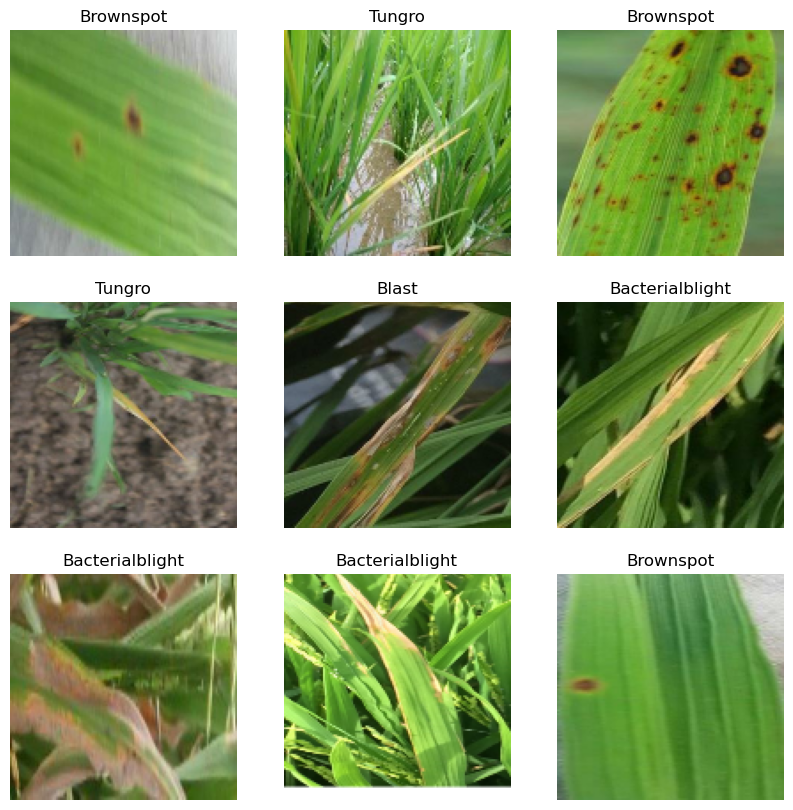

In [13]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [14]:
model = tf.keras.Sequential(
    [
     tf.keras.layers.Rescaling(1./255),
     tf.keras.layers.Conv2D(65, 3, activation="relu"),
     tf.keras.layers.MaxPooling2D(),
     tf.keras.layers.Conv2D(35, 3, activation="relu"),
     tf.keras.layers.MaxPooling2D(),
     tf.keras.layers.Conv2D(64, 3, activation="relu"),
     tf.keras.layers.MaxPooling2D(),
     tf.keras.layers.Flatten(),
     tf.keras.layers.Dense(128, activation="relu"),
     tf.keras.layers.Dense(6)
    ]
)

In [15]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [16]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    verbose=1,
    epochs=7,
)

Epoch 1/7
237/237 ━━━━━━━━━━━━━━━━━━━━ 66s 204ms/step - accuracy: 0.5251 - loss: 1.1106 - val_accuracy: 0.7431 - val_loss: 0.6707
Epoch 2/7
237/237 ━━━━━━━━━━━━━━━━━━━━ 51s 201ms/step - accuracy: 0.8084 - loss: 0.4939 - val_accuracy: 0.8828 - val_loss: 0.2851
Epoch 3/7
237/237 ━━━━━━━━━━━━━━━━━━━━ 50s 198ms/step - accuracy: 0.8903 - loss: 0.2955 - val_accuracy: 0.9793 - val_loss: 0.0970
Epoch 4/7
237/237 ━━━━━━━━━━━━━━━━━━━━ 50s 199ms/step - accuracy: 0.9634 - loss: 0.1124 - val_accuracy: 0.9828 - val_loss: 0.0786
Epoch 5/7
237/237 ━━━━━━━━━━━━━━━━━━━━ 50s 200ms/step - accuracy: 0.9843 - loss: 0.0568 - val_accuracy: 1.0000 - val_loss: 0.0093
Epoch 6/7
237/237 ━━━━━━━━━━━━━━━━━━━━ 51s 202ms/step - accuracy: 0.9909 - loss: 0.0311 - val_accuracy: 0.9931 - val_loss: 0.0226
Epoch 7/7
237/237 ━━━━━━━━━━━━━━━━━━━━ 51s 201ms/step - accuracy: 0.9953 - loss: 0.0152 - val_accuracy: 1.0000 - val_loss: 0.0024


In [17]:
scores = model.evaluate(test_ds)

31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 1.0000 - loss: 0.0036


In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 126, 126, 65)        │           1,820 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 65)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 35)          │          20,510 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 35)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 64)          │          20,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,947,266 (18.87 MB)

 Trainable params: 1,649,088 (6.29 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,298,178 (12.58 MB)

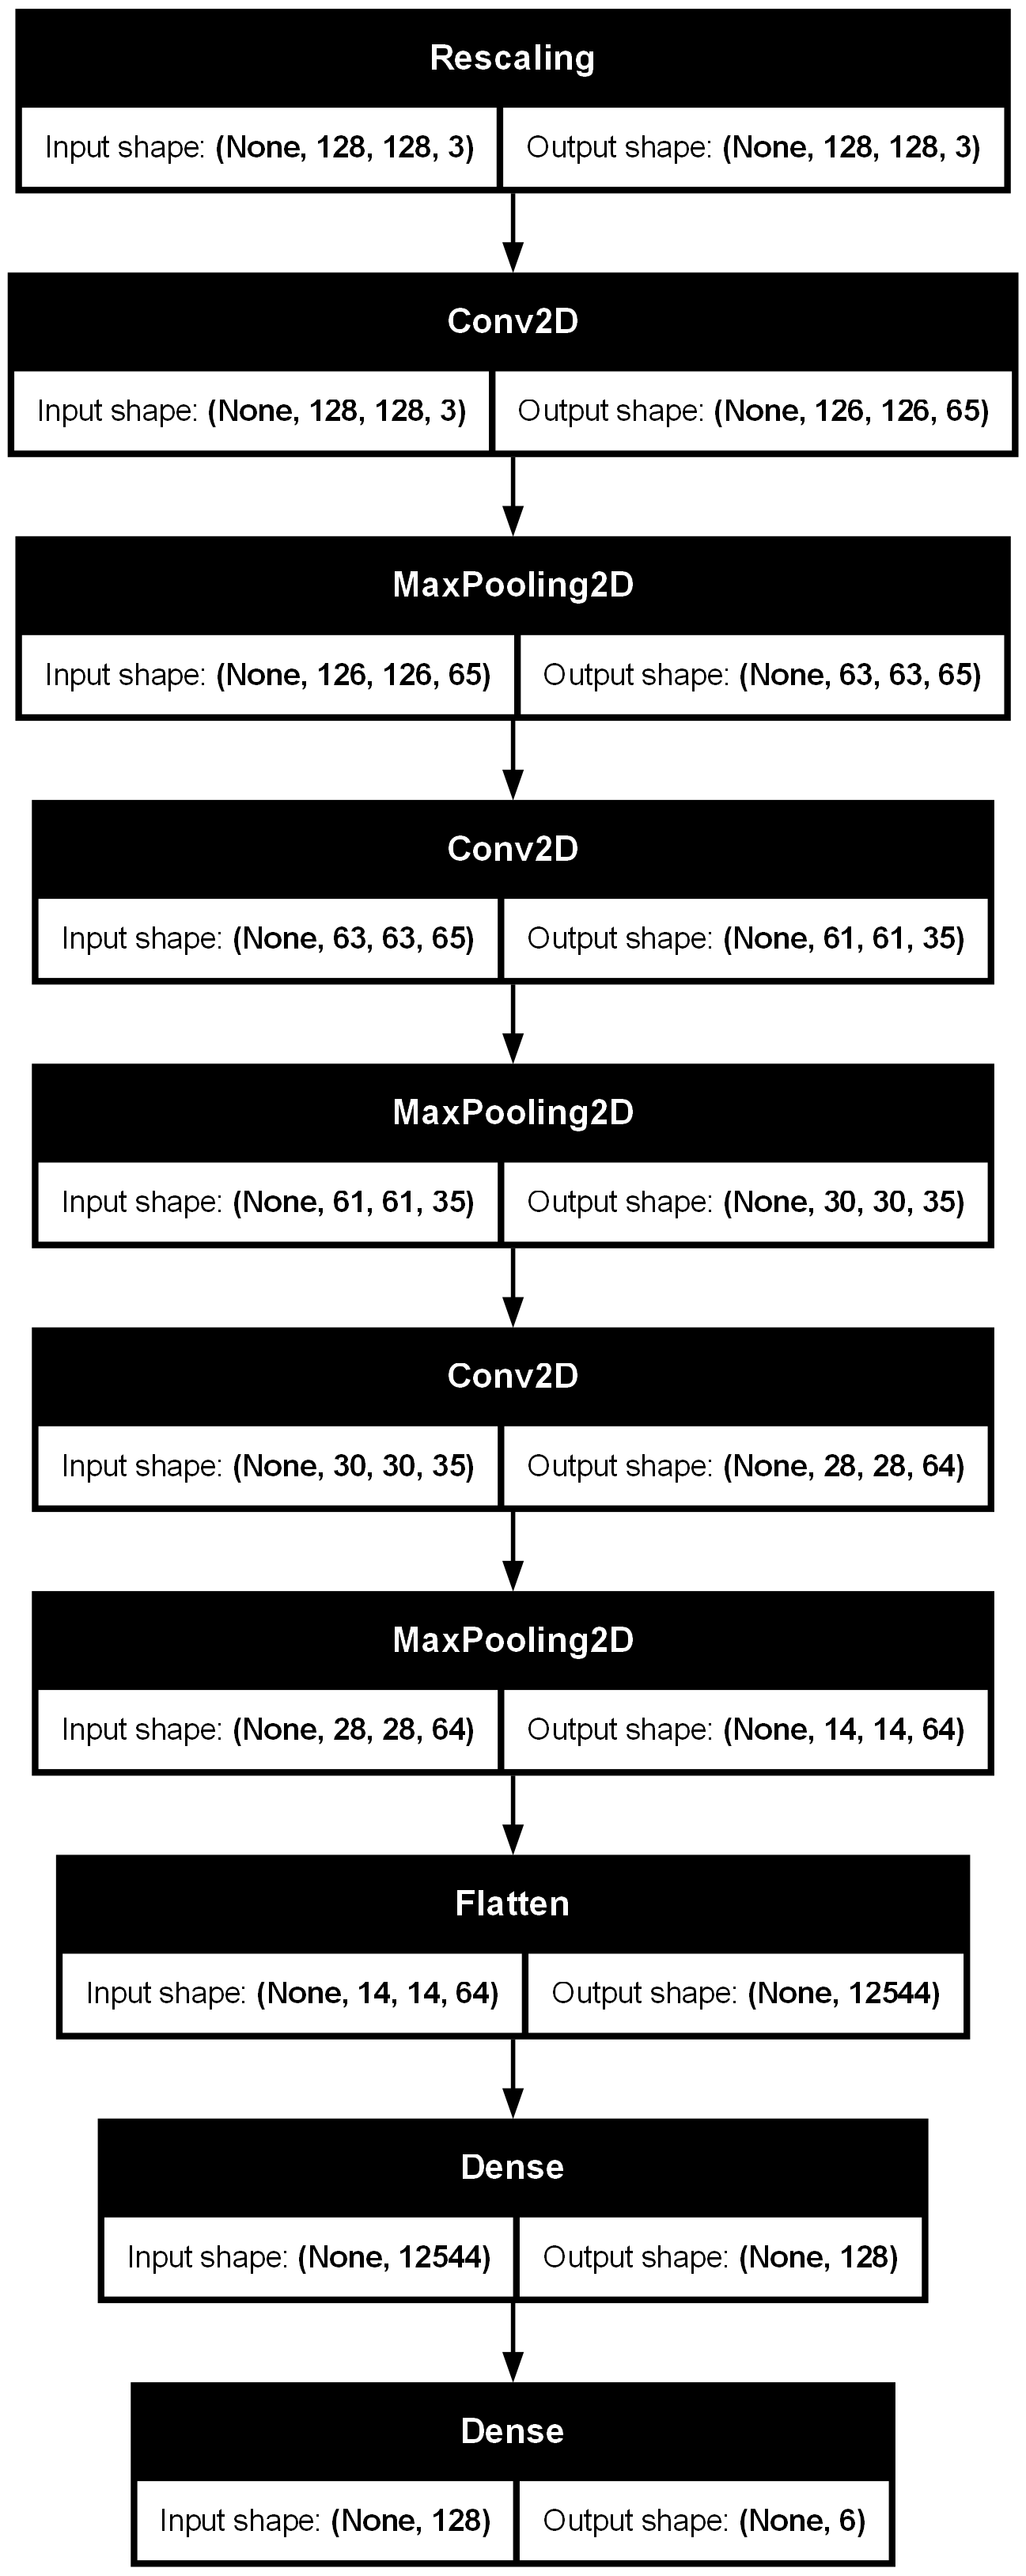

In [19]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [20]:
history

In [21]:
history.params

{'verbose': 1, 'epochs': 7, 'steps': 237}

In [22]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

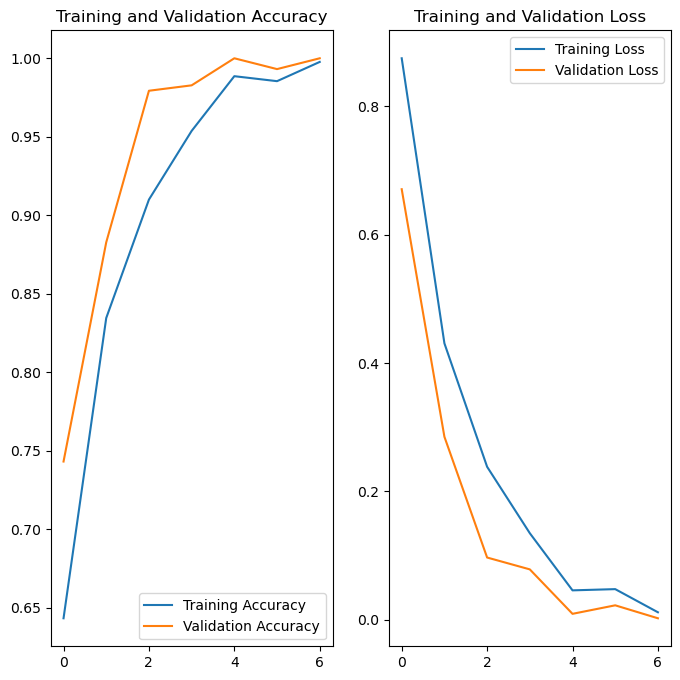

In [24]:
EPOCHS=7
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

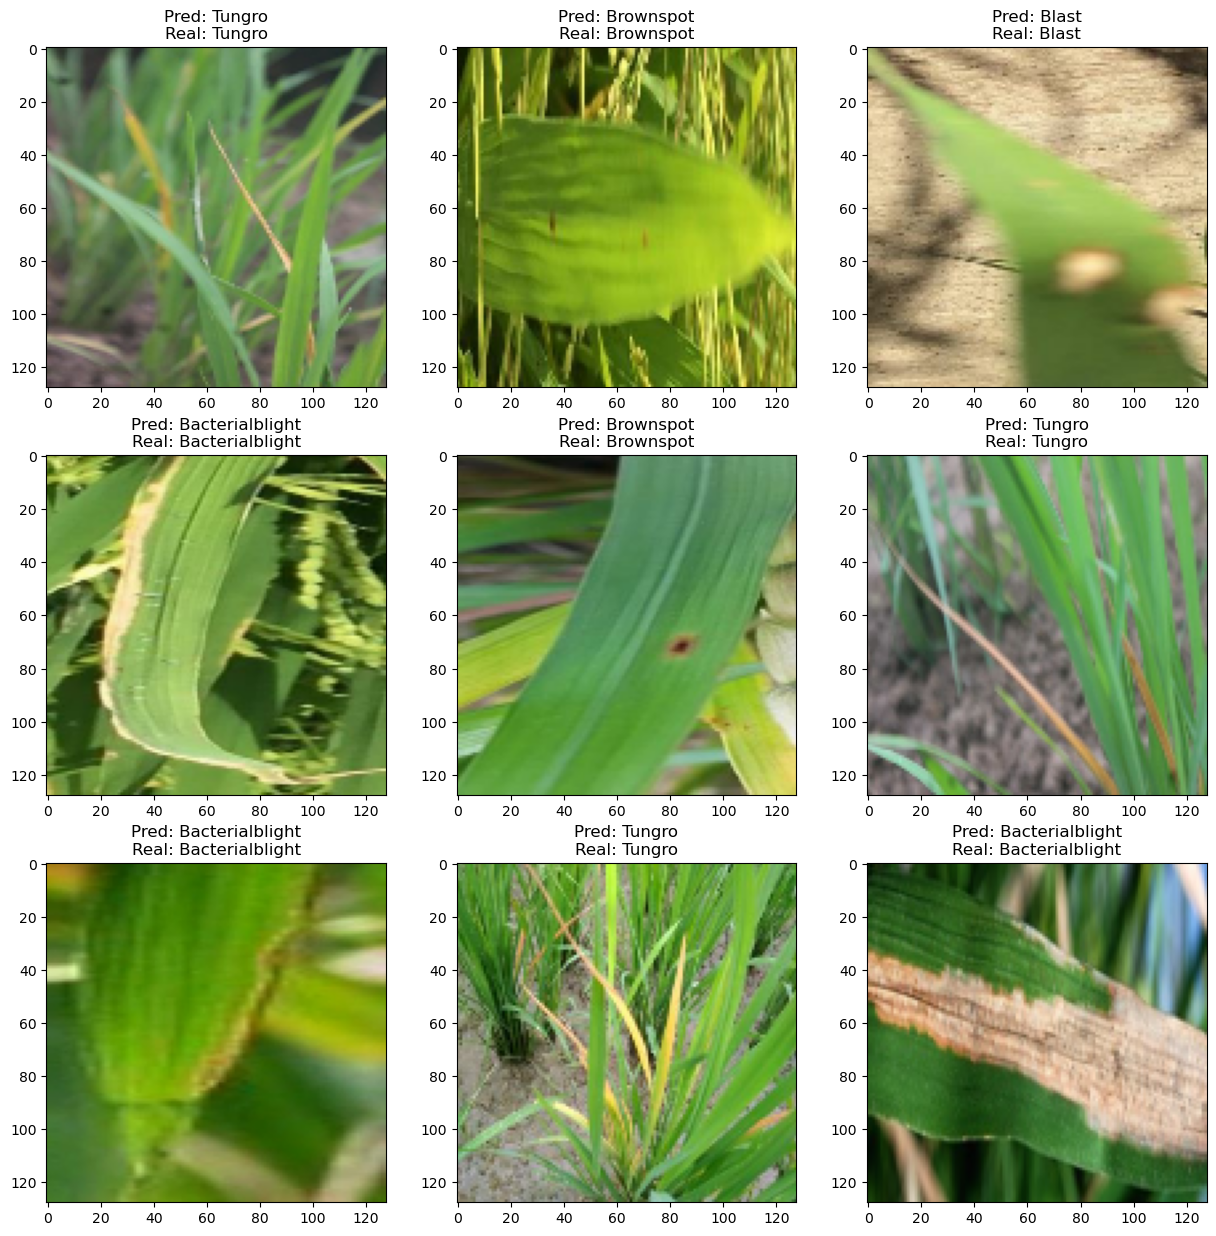

In [25]:
import numpy

plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    classifications = model(images)
  #print(classifications)

    for i in range(9):
               
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        index = numpy.argmax(classifications[i])
        #print(index)
        plt.title("Pred: " + class_names[index] + "\nReal: " + class_names[labels[i]])

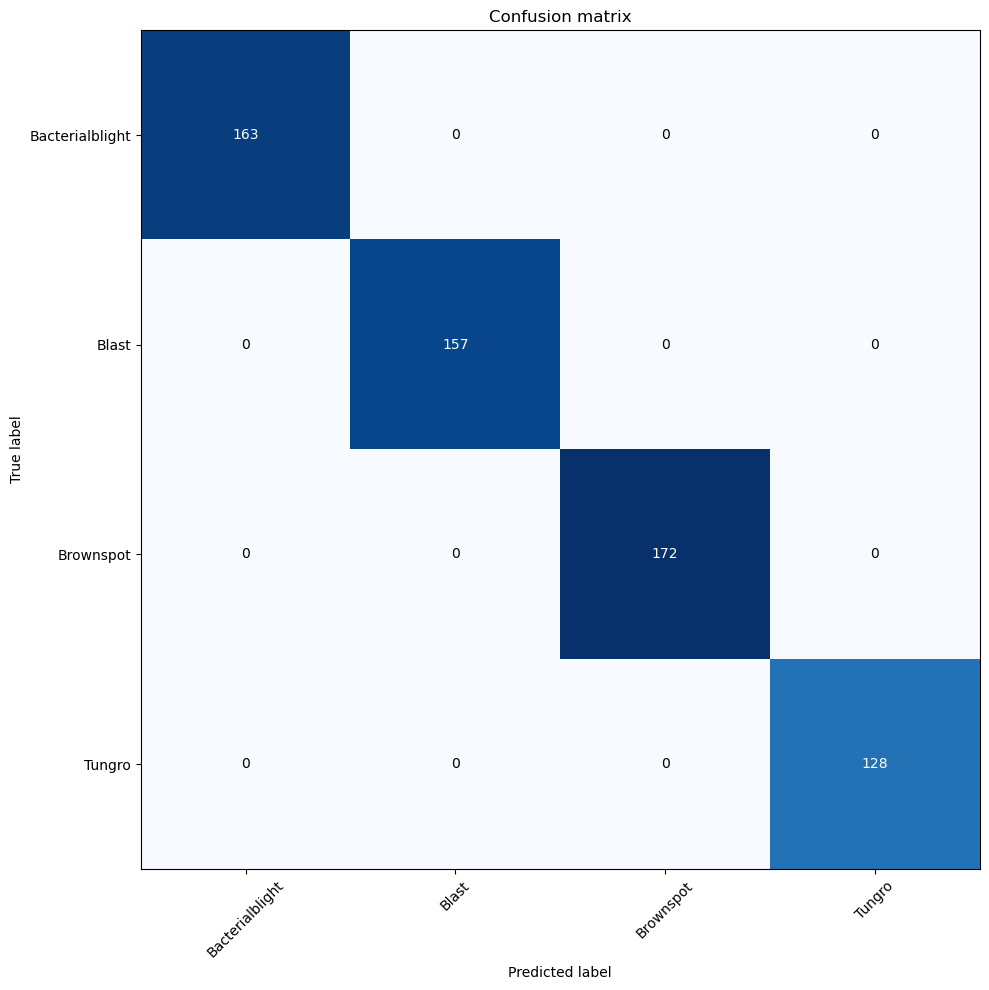

In [26]:
all_predicted_labels = []
all_actual_labels = []

for images, labels in test_ds:
    classifications = model(images)
    predicted_labels = [np.argmax(classification) for classification in classifications.numpy()]
    all_predicted_labels.extend(predicted_labels)
    all_actual_labels.extend(labels.numpy())

# Create confusion matrix
conf_matrix = confusion_matrix(all_actual_labels, all_predicted_labels)

# Plot confusion matrix with numbers
plt.figure(figsize=(10, 10))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
#plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')


thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

In [27]:
from sklearn.metrics import classification_report

report = classification_report(all_actual_labels, all_predicted_labels, target_names=class_names)


print(report)

                 precision    recall  f1-score   support

Bacterialblight       1.00      1.00      1.00       163
          Blast       1.00      1.00      1.00       157
      Brownspot       1.00      1.00      1.00       172
         Tungro       1.00      1.00      1.00       128

       accuracy                           1.00       620
      macro avg       1.00      1.00      1.00       620
   weighted avg       1.00      1.00      1.00       620

